# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 10
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


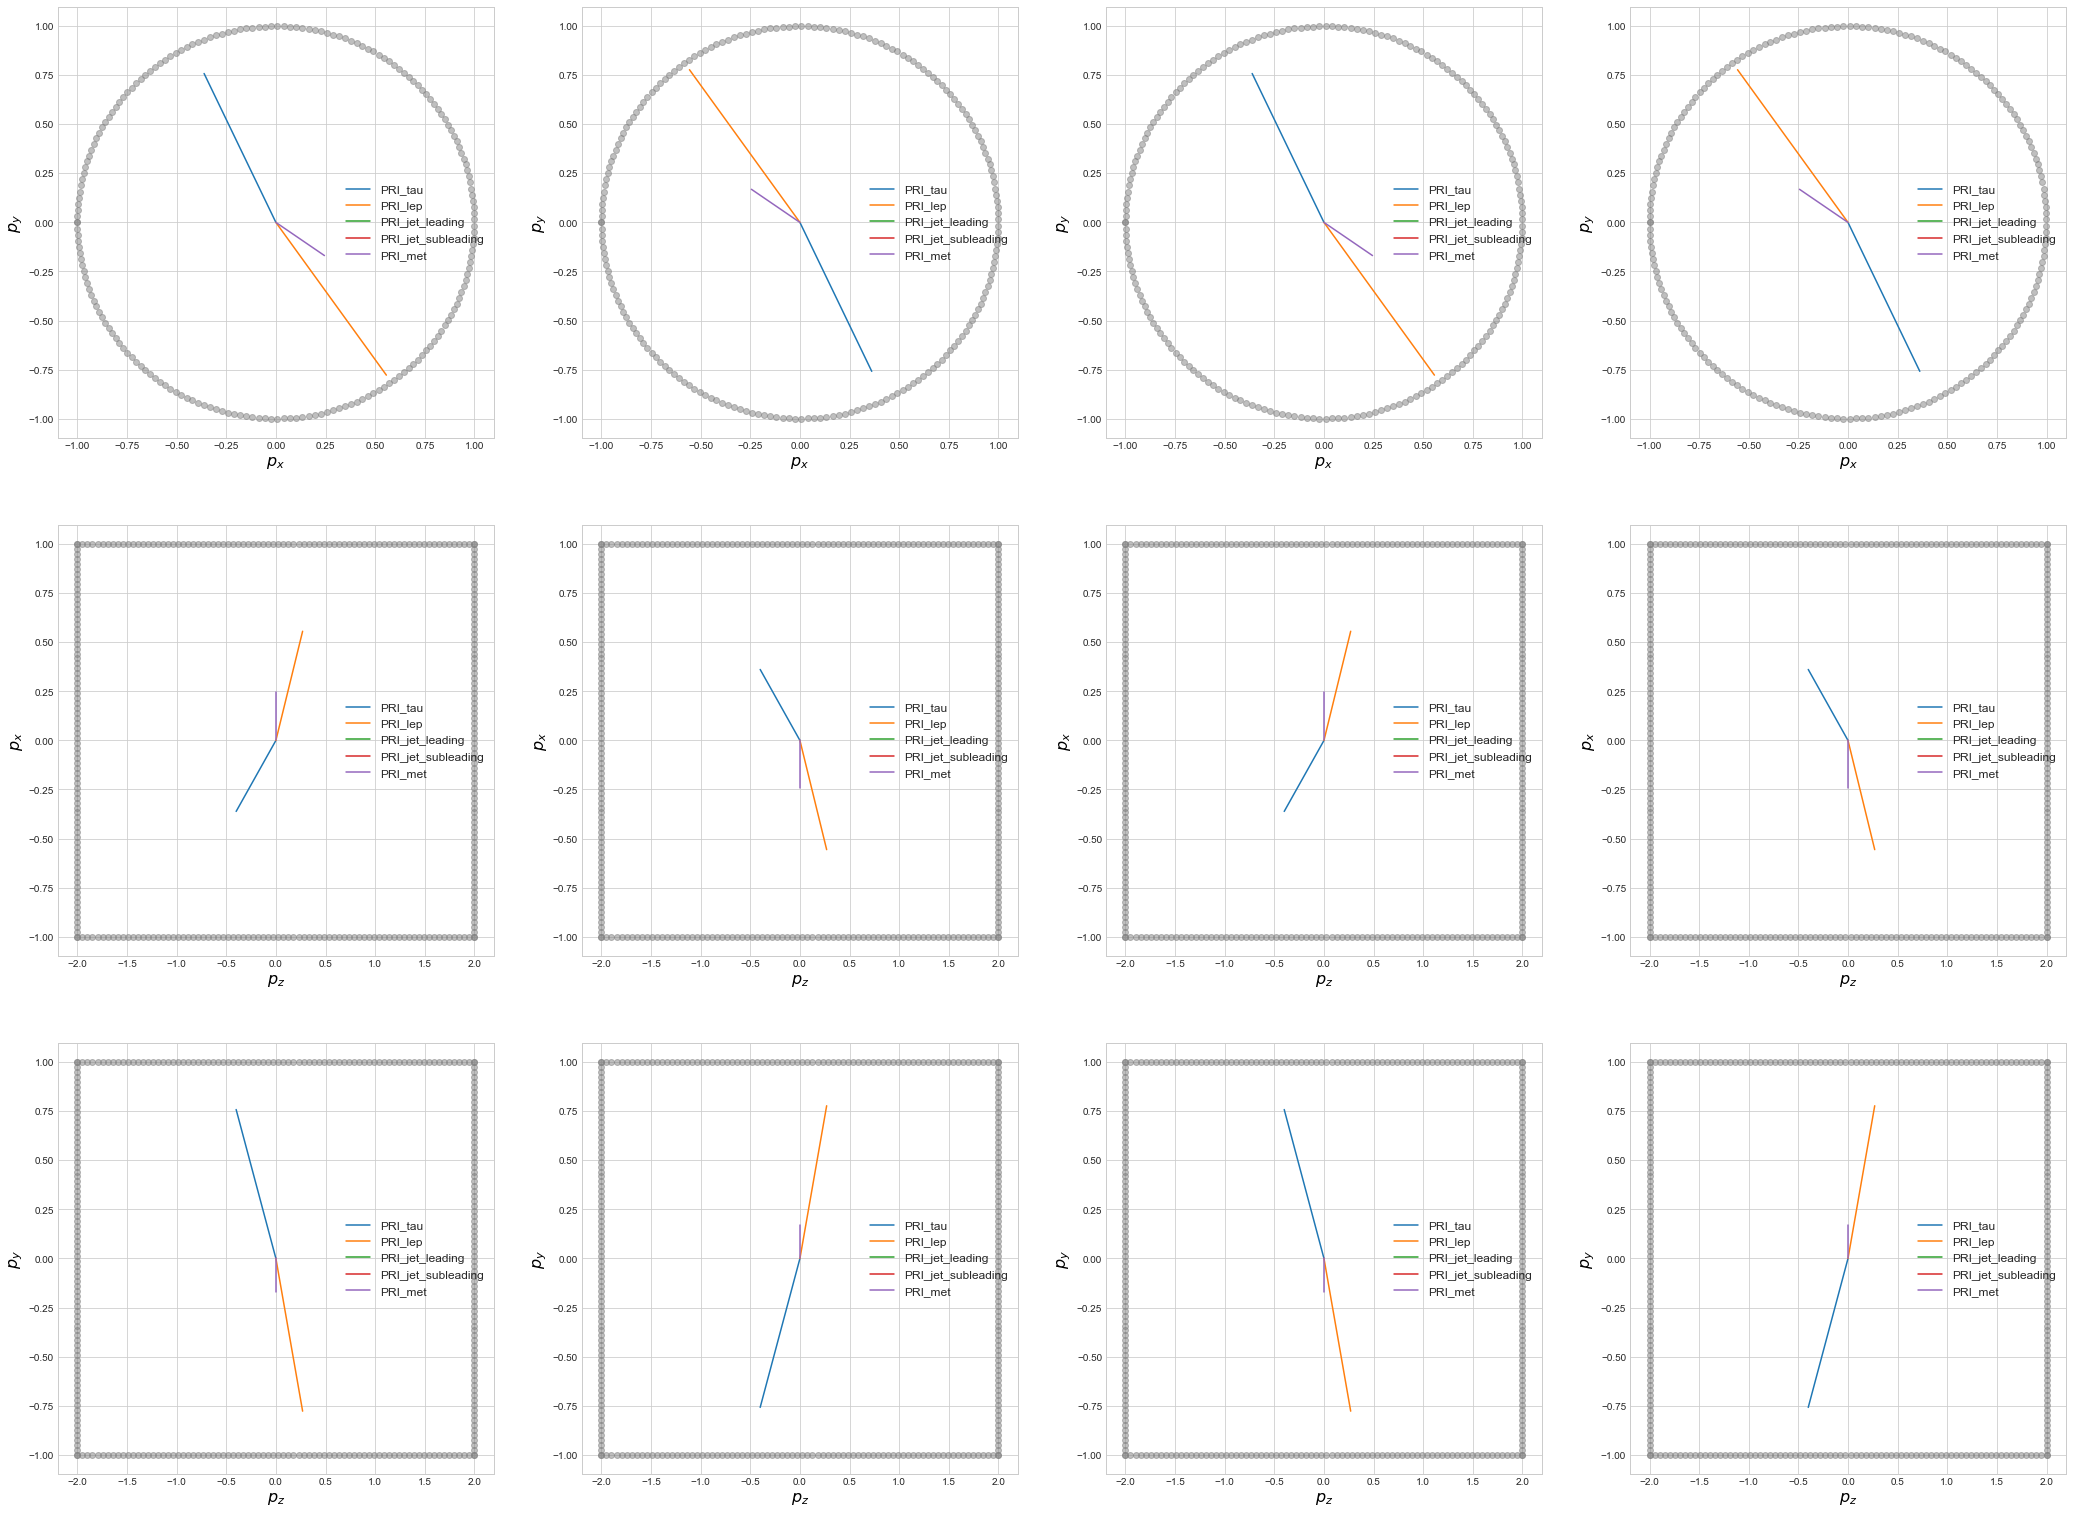

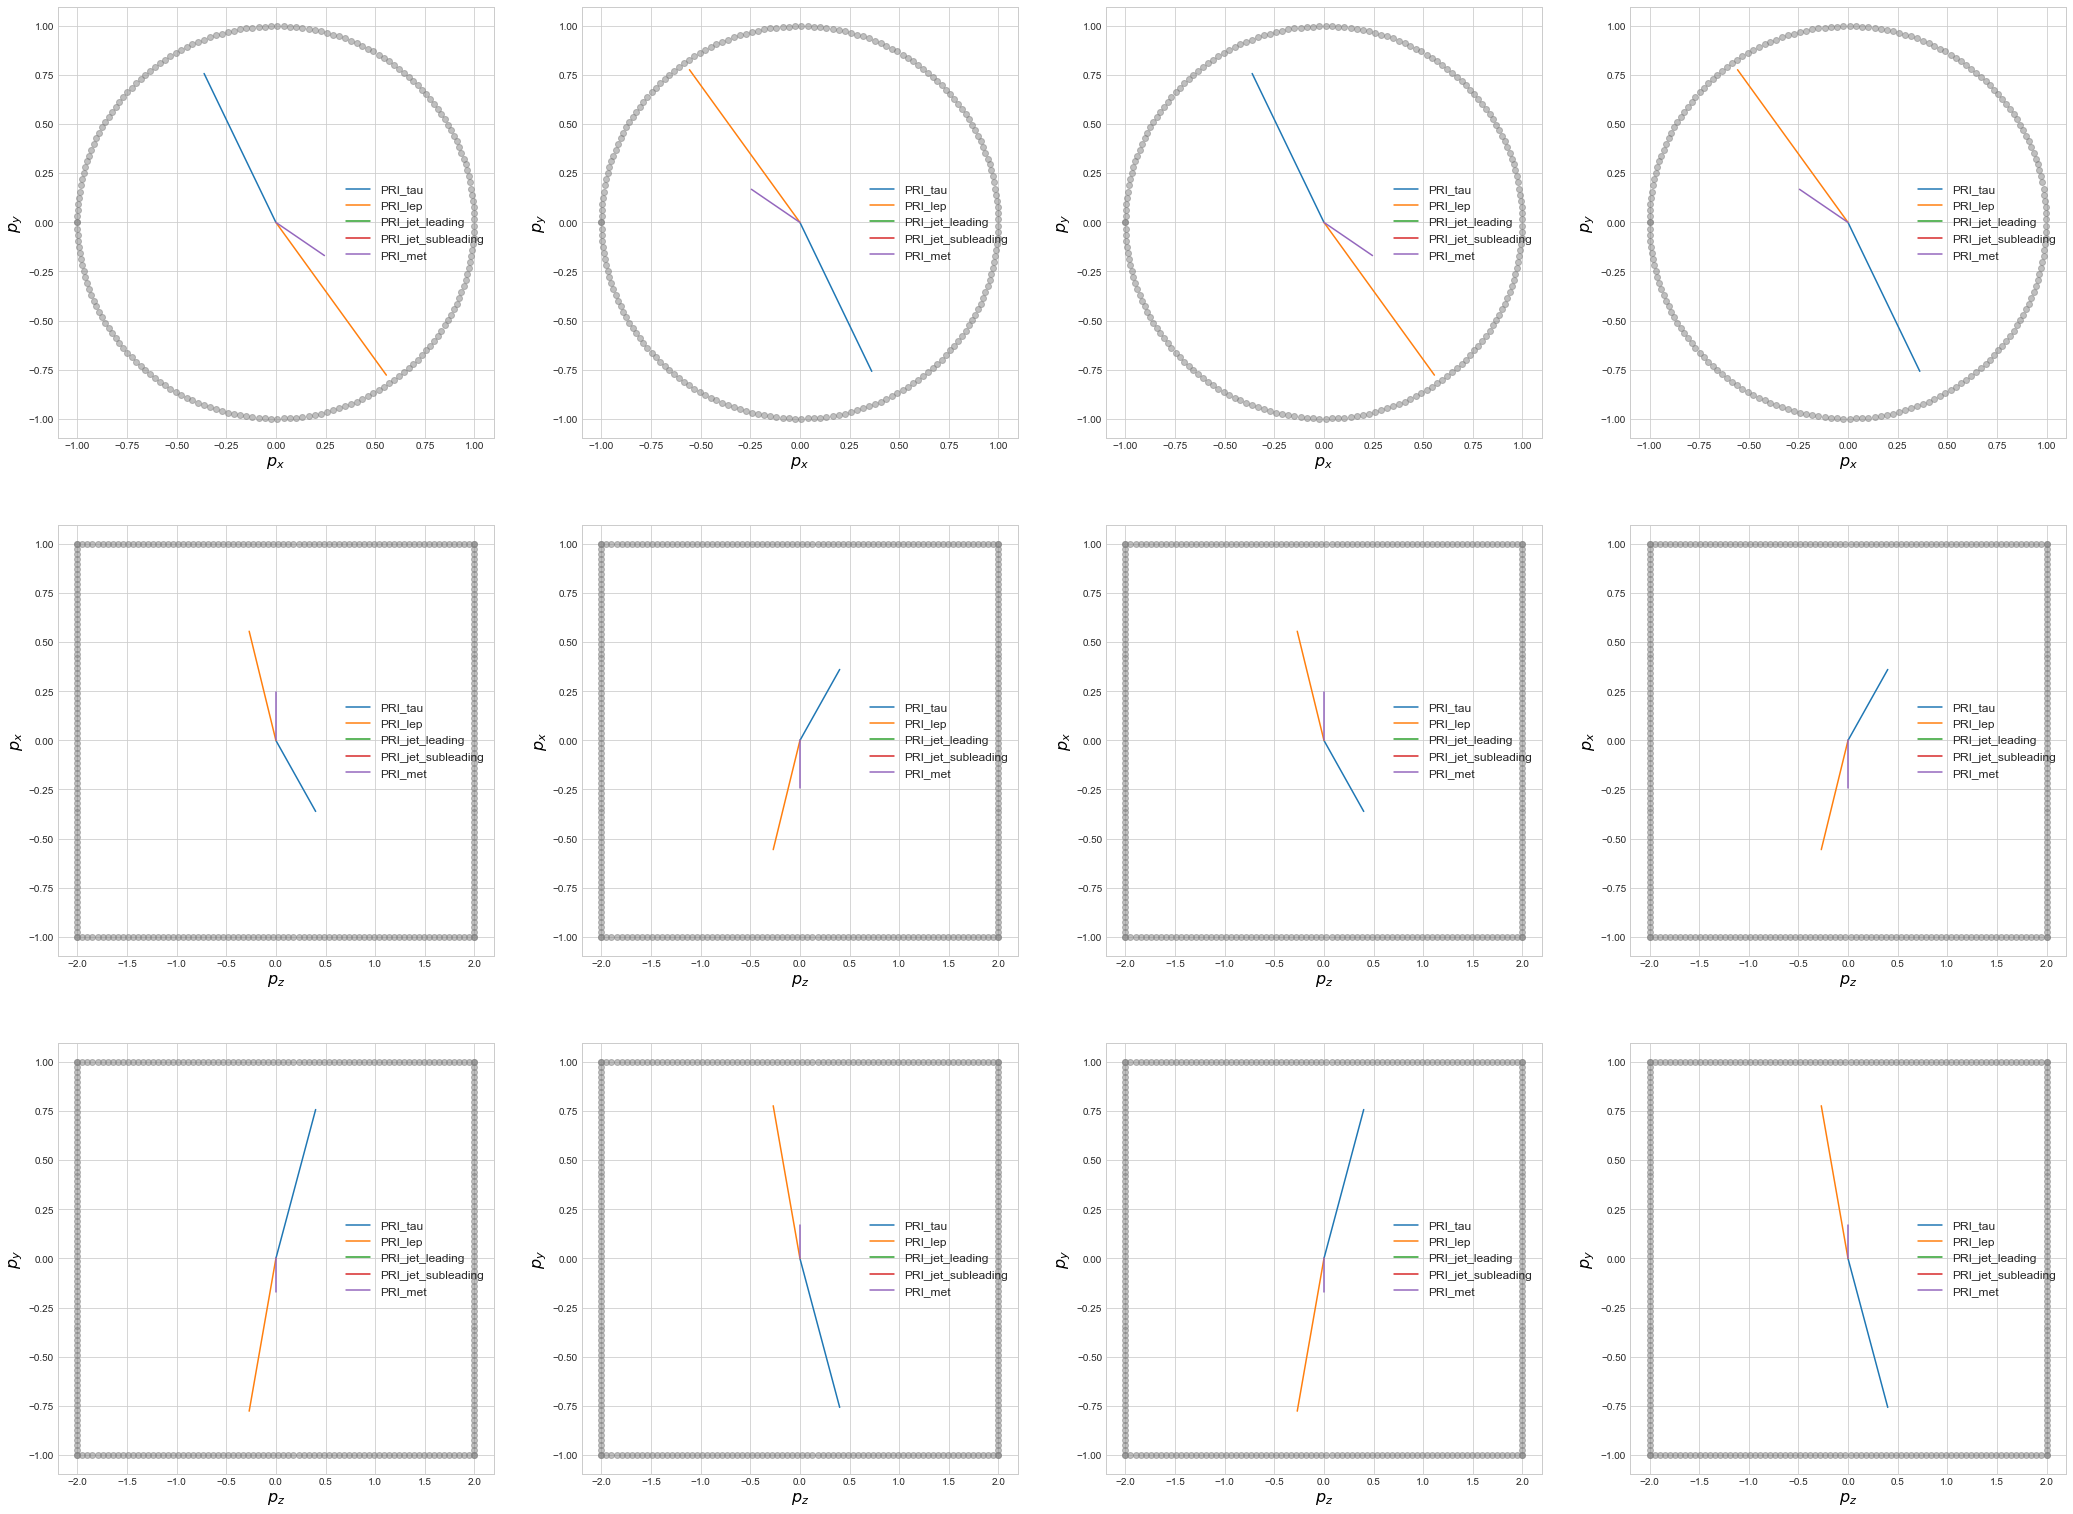

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.551s 


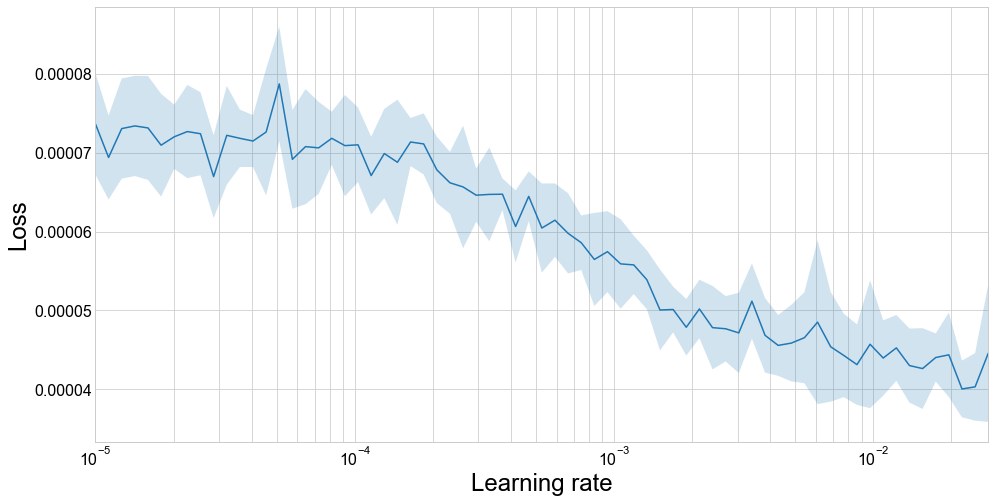

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'LinearCLR':{'reverse':False, 'max_lr':2e-3, 'min_lr':2e-4, 'scale':2},
                 'SWA':{'renewal':5, 'sgd_replacement':False, 'start':1},}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using linear LR cycle
2 classes found, running in binary mode

1 New best found: 4.136152711162148e-05
2 New best found: 3.7873943724276366e-05
3 New best found: 3.685447523089588e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.519588674060838e-05, default loss 3.519588674060838e-05
Saving snapshot 1
4 New best found: 3.519588674060838e-05
5 swa loss 3.519588674060838e-05, default loss 3.5117940348561966e-05
5 New best found: 3.5117940348561966e-05
6 swa loss 3.519588674060838e-05, default loss 3.460033869317695e-05
6 New best found: 3.460033869317695e-05
7 swa loss 3.519588674060838e-05, default loss 3.410838664707276e-05
7 New best found: 3.410838664707276e-05
model is 1 epochs old
8 swa loss 3.410139657221655e-05, default loss 3.367197611443171e-05
Saving snapshot 2
8 New best found: 3.367197611443171e-05
9 swa loss 3.410139657221655e-05, default loss 3.36911341759687e-05
10 swa loss 3.410139657221655e-05, default loss 3.455078052961

84 swa loss 3.1677190243727105e-05, default loss 3.178205965651373e-05
Saving snapshot 21
84 New best found: 3.1677190243727105e-05
85 swa loss 3.1677190243727105e-05, default loss 3.198892166885048e-05
85 New best found: 3.1677190243727105e-05
86 swa loss 3.1677190243727105e-05, default loss 3.239763602457613e-05
86 New best found: 3.1677190243727105e-05
87 swa loss 3.1677190243727105e-05, default loss 3.2134210056692913e-05
87 New best found: 3.1677190243727105e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.1659601942304395e-05, default loss 3.1836993303856205e-05
Saving snapshot 22
88 New best found: 3.1659601942304395e-05
89 swa loss 3.1659601942304395e-05, default loss 3.1845663034473575e-05
89 New best found: 3.1659601942304395e-05
90 swa loss 3.1659601942304395e-05, default loss 3.24108372437611e-05
90 New best found: 3.1659601942304395e-05
91 swa loss 3.1659601942304395e-05, default loss 3.207831174007686e-05
91 New best found: 3.1659601942304395e-05
model i

144 swa loss 3.134653183889201e-05, default loss 3.1552922227951055e-05
Saving snapshot 36
144 New best found: 3.134653183889201e-05
145 swa loss 3.134653183889201e-05, default loss 3.1779053513894645e-05
145 New best found: 3.134653183889201e-05
146 swa loss 3.134653183889201e-05, default loss 3.214528266112502e-05
146 New best found: 3.134653183889201e-05
147 swa loss 3.134653183889201e-05, default loss 3.189321757215874e-05
147 New best found: 3.134653183889201e-05
model is 6 epochs old
new model is 1 epochs old
148 swa loss 3.133603666368254e-05, default loss 3.164905907235417e-05
Saving snapshot 37
148 New best found: 3.133603666368254e-05
149 swa loss 3.133603666368254e-05, default loss 3.1686099468688766e-05
149 New best found: 3.133603666368254e-05
150 swa loss 3.133603666368254e-05, default loss 3.205437931759574e-05
150 New best found: 3.133603666368254e-05
151 swa loss 3.133603666368254e-05, default loss 3.172654143541956e-05
151 New best found: 3.133603666368254e-05
model i

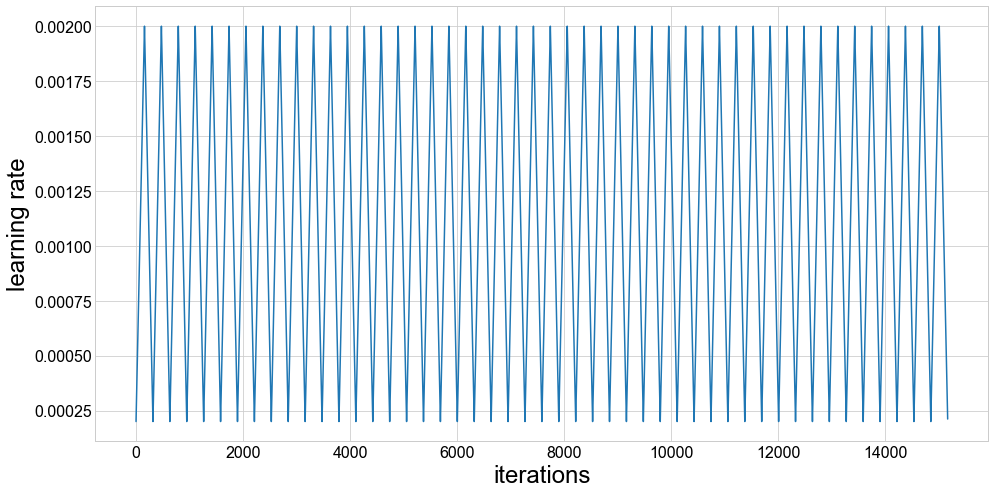

Fold took 178.960s

Training model 2 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109274). Check your callbacks.
  % delta_t_median)


1 New best found: 4.3049828040898104e-05
2 New best found: 4.240210630544595e-05
3 New best found: 3.672049502659959e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.621494244157185e-05, default loss 3.621494244157185e-05
Saving snapshot 1
4 New best found: 3.621494244157185e-05
5 swa loss 3.621494244157185e-05, default loss 3.645157403822142e-05
5 New best found: 3.621494244157185e-05
6 swa loss 3.621494244157185e-05, default loss 3.688791708751695e-05
6 New best found: 3.621494244157185e-05
7 swa loss 3.621494244157185e-05, default loss 3.6099512814219164e-05
7 New best found: 3.6099512814219164e-05
model is 1 epochs old
8 swa loss 3.543583969960299e-05, default loss 3.516726835828867e-05
Saving snapshot 2
8 New best found: 3.516726835828867e-05
9 swa loss 3.543583969960299e-05, default loss 3.5436434788208133e-05
10 swa loss 3.543583969960299e-05, default loss 3.605553454609757e-05
11 swa loss 3.543583969960299e-05, default loss 3.5319774227016155e-05
model is 2 epochs old
12 sw

84 swa loss 3.3676548365650144e-05, default loss 3.386063060340474e-05
Saving snapshot 21
84 New best found: 3.3676548365650144e-05
85 swa loss 3.3676548365650144e-05, default loss 3.4261176272908944e-05
85 New best found: 3.3676548365650144e-05
86 swa loss 3.3676548365650144e-05, default loss 3.467532306521402e-05
86 New best found: 3.3676548365650144e-05
87 swa loss 3.3676548365650144e-05, default loss 3.431825667997761e-05
87 New best found: 3.3676548365650144e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.3663628890024136e-05, default loss 3.3876540407648595e-05
Saving snapshot 22
88 New best found: 3.3663628890024136e-05
89 swa loss 3.3663628890024136e-05, default loss 3.420276601926547e-05
89 New best found: 3.3663628890024136e-05
90 swa loss 3.3663628890024136e-05, default loss 3.436716043395287e-05
90 New best found: 3.3663628890024136e-05
91 swa loss 3.3663628890024136e-05, default loss 3.449875190038446e-05
91 New best found: 3.3663628890024136e-05
model i

model is 16 epochs old
new model is 6 epochs old
148 swa loss 3.352185734484304e-05, default loss 3.385574770408572e-05
Saving snapshot 37
148 New best found: 3.352185734484304e-05
149 swa loss 3.352185734484304e-05, default loss 3.370477683255437e-05
149 New best found: 3.352185734484304e-05
150 swa loss 3.352185734484304e-05, default loss 3.470556072088306e-05
150 New best found: 3.352185734484304e-05
151 swa loss 3.352185734484304e-05, default loss 3.4357064420813597e-05
151 New best found: 3.352185734484304e-05
model is 17 epochs old
new model is 7 epochs old
152 swa loss 3.3519497804032075e-05, default loss 3.382412449928728e-05
Saving snapshot 38
152 New best found: 3.3519497804032075e-05
153 swa loss 3.3519497804032075e-05, default loss 3.3644105658407735e-05
153 New best found: 3.3519497804032075e-05
154 swa loss 3.3519497804032075e-05, default loss 3.418563803991093e-05
154 New best found: 3.3519497804032075e-05
155 swa loss 3.3519497804032075e-05, default loss 3.3734183236391

214 swa loss 3.3367465958090845e-05, default loss 3.416828116320675e-05
214 New best found: 3.3367465958090845e-05
215 swa loss 3.3367465958090845e-05, default loss 3.389825863589378e-05
215 New best found: 3.3367465958090845e-05
model is 23 epochs old
new model is 8 epochs old
216 swa loss 3.33650800176967e-05, default loss 3.3615831103535326e-05
Saving snapshot 54
216 New best found: 3.33650800176967e-05
217 swa loss 3.33650800176967e-05, default loss 3.378521812437954e-05
217 New best found: 3.33650800176967e-05
218 swa loss 3.33650800176967e-05, default loss 3.3965428148078844e-05
218 New best found: 3.33650800176967e-05
219 swa loss 3.33650800176967e-05, default loss 3.3798684235838626e-05
219 New best found: 3.33650800176967e-05
model is 24 epochs old
new model is 9 epochs old
220 swa loss 3.336550874179451e-05, default loss 3.383506149572595e-05
Saving snapshot 55
221 swa loss 3.336550874179451e-05, default loss 3.356535087076746e-05
222 swa loss 3.336550874179451e-05, default l

293 swa loss 3.336024527614715e-05, default loss 3.3798257742017274e-05
294 swa loss 3.336024527614715e-05, default loss 3.3951905910096986e-05
295 swa loss 3.336024527614715e-05, default loss 3.396693139153968e-05
model is 43 epochs old
new model is 3 epochs old
296 swa loss 3.336268371478226e-05, default loss 3.3933135237793486e-05
Saving snapshot 74
297 swa loss 3.336268371478226e-05, default loss 3.3826054416503995e-05
298 swa loss 3.336268371478226e-05, default loss 3.415025723730087e-05
299 swa loss 3.336268371478226e-05, default loss 3.383800156303531e-05
model is 44 epochs old
new model is 4 epochs old
300 swa loss 3.33623217309913e-05, default loss 3.3755378365082725e-05
Saving snapshot 75
301 swa loss 3.33623217309913e-05, default loss 3.3993273641152216e-05
302 swa loss 3.33623217309913e-05, default loss 3.4330106921197846e-05
303 swa loss 3.33623217309913e-05, default loss 3.4023462309395365e-05
model is 45 epochs old
new model is 5 epochs old
304 swa loss 3.336170085485663

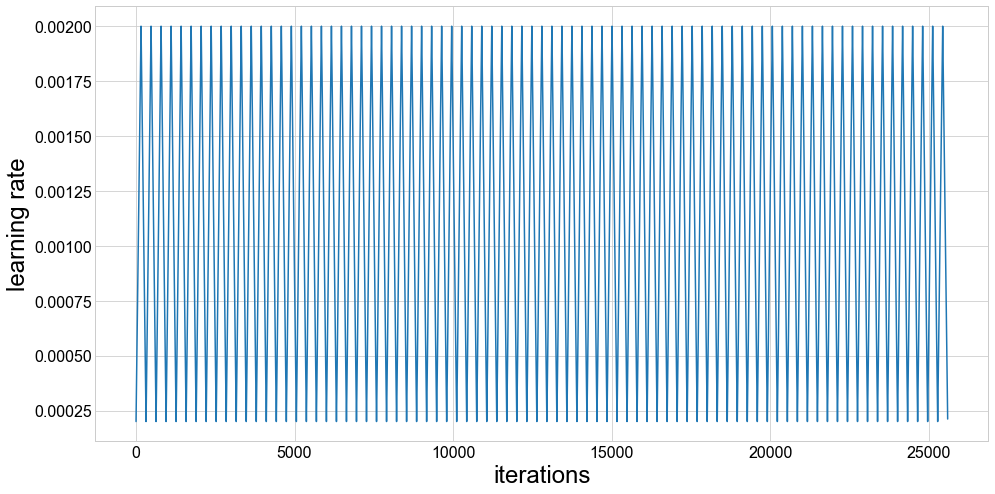

Fold took 327.434s

Training model 3 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119062). Check your callbacks.
  % delta_t_median)


1 New best found: 4.090570257569087e-05
2 New best found: 3.824962836069332e-05
3 New best found: 3.665362785472887e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.574511746836412e-05, default loss 3.574511746836412e-05
Saving snapshot 1
4 New best found: 3.574511746836412e-05
5 swa loss 3.574511746836412e-05, default loss 3.634937732190211e-05
5 New best found: 3.574511746836412e-05
6 swa loss 3.574511746836412e-05, default loss 3.61231042483654e-05
6 New best found: 3.574511746836412e-05
7 swa loss 3.574511746836412e-05, default loss 3.529125010105214e-05
7 New best found: 3.529125010105214e-05
model is 1 epochs old
8 swa loss 3.488098472506438e-05, default loss 3.46508245761682e-05
Saving snapshot 2
8 New best found: 3.46508245761682e-05
9 swa loss 3.488098472506438e-05, default loss 3.4759447364544834e-05
10 swa loss 3.488098472506438e-05, default loss 3.567295577383127e-05
11 swa loss 3.488098472506438e-05, default loss 3.47122591800669e-05
model is 2 epochs old
12 swa loss 3

86 swa loss 3.2352081729957496e-05, default loss 3.272974386873294e-05
86 New best found: 3.2352081729957496e-05
87 swa loss 3.2352081729957496e-05, default loss 3.251806478231897e-05
87 New best found: 3.2352081729957496e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.23280676788924e-05, default loss 3.244431849637103e-05
Saving snapshot 22
88 New best found: 3.23280676788924e-05
89 swa loss 3.23280676788924e-05, default loss 3.253051086615165e-05
89 New best found: 3.23280676788924e-05
90 swa loss 3.23280676788924e-05, default loss 3.275748671819459e-05
90 New best found: 3.23280676788924e-05
91 swa loss 3.23280676788924e-05, default loss 3.2989152616771995e-05
91 New best found: 3.23280676788924e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.2311290244282096e-05, default loss 3.25085418678652e-05
Saving snapshot 23
92 New best found: 3.2311290244282096e-05
93 swa loss 3.2311290244282096e-05, default loss 3.2765909927140474e-05
93 New best found

146 swa loss 3.199391199304935e-05, default loss 3.2633384646334326e-05
146 New best found: 3.199391199304935e-05
147 swa loss 3.199391199304935e-05, default loss 3.2485884510731095e-05
147 New best found: 3.199391199304935e-05
model is 11 epochs old
new model is 1 epochs old
148 swa loss 3.1975527130299085e-05, default loss 3.215294428716284e-05
Saving snapshot 37
148 New best found: 3.1975527130299085e-05
149 swa loss 3.1975527130299085e-05, default loss 3.227974047954381e-05
149 New best found: 3.1975527130299085e-05
150 swa loss 3.1975527130299085e-05, default loss 3.243565507507767e-05
150 New best found: 3.1975527130299085e-05
151 swa loss 3.1975527130299085e-05, default loss 3.261644182540323e-05
151 New best found: 3.1975527130299085e-05
model is 12 epochs old
new model is 2 epochs old
152 swa loss 3.1975797304008065e-05, default loss 3.2336107328523907e-05
Saving snapshot 38
153 swa loss 3.1975797304008065e-05, default loss 3.230842075272254e-05
154 swa loss 3.1975797304008065

209 swa loss 3.187882795129952e-05, default loss 3.232711863662037e-05
209 New best found: 3.187882795129952e-05
210 swa loss 3.187882795129952e-05, default loss 3.243102534043658e-05
210 New best found: 3.187882795129952e-05
211 swa loss 3.187882795129952e-05, default loss 3.233602836795914e-05
211 New best found: 3.187882795129952e-05
model is 7 epochs old
new model is 2 epochs old
212 swa loss 3.1876659004161426e-05, default loss 3.217262566349686e-05
Saving snapshot 53
212 New best found: 3.1876659004161426e-05
213 swa loss 3.1876659004161426e-05, default loss 3.220150930232376e-05
213 New best found: 3.1876659004161426e-05
214 swa loss 3.1876659004161426e-05, default loss 3.2546847355877606e-05
214 New best found: 3.1876659004161426e-05
215 swa loss 3.1876659004161426e-05, default loss 3.2268671238182865e-05
215 New best found: 3.1876659004161426e-05
model is 8 epochs old
new model is 3 epochs old
216 swa loss 3.186810447806789e-05, default loss 3.2173116087370096e-05
Saving snaps

284 swa loss 3.185179942923523e-05, default loss 3.2261846172309564e-05
Saving snapshot 71
285 swa loss 3.185179942923523e-05, default loss 3.2154606746439445e-05
286 swa loss 3.185179942923523e-05, default loss 3.256386767618413e-05
287 swa loss 3.185179942923523e-05, default loss 3.2269505653235306e-05
model is 26 epochs old
new model is 6 epochs old
288 swa loss 3.184986658855418e-05, default loss 3.219594577673212e-05
Saving snapshot 72
289 swa loss 3.184986658855418e-05, default loss 3.235758349355602e-05
290 swa loss 3.184986658855418e-05, default loss 3.255880305380087e-05
291 swa loss 3.184986658855418e-05, default loss 3.2235216594337117e-05
model is 27 epochs old
new model is 7 epochs old
292 swa loss 3.184352476588404e-05, default loss 3.2060980245190535e-05
Saving snapshot 73
293 swa loss 3.184352476588404e-05, default loss 3.224089575931988e-05
294 swa loss 3.184352476588404e-05, default loss 3.253718353852784e-05
295 swa loss 3.184352476588404e-05, default loss 3.24647438

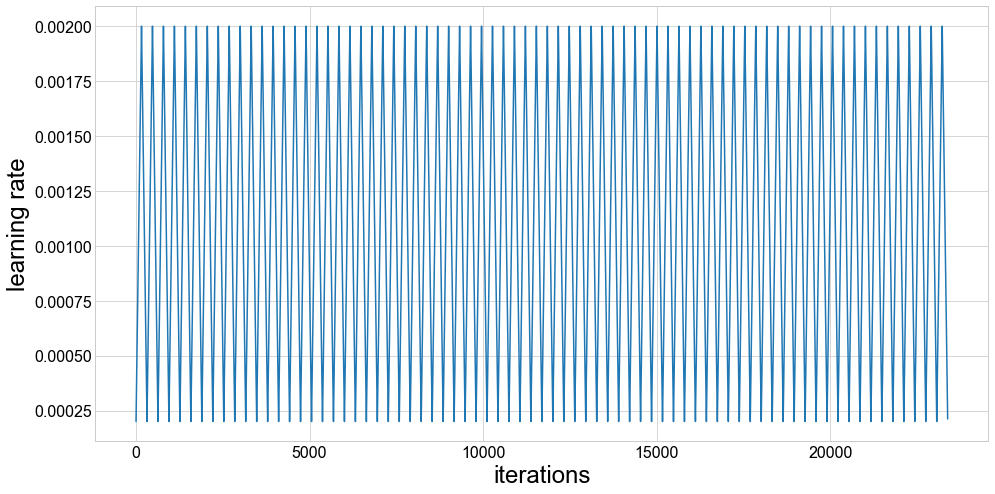

Fold took 321.916s

Training model 4 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123277). Check your callbacks.
  % delta_t_median)


1 New best found: 3.954302310201902e-05
2 New best found: 3.676568731883482e-05
3 New best found: 3.563527576370967e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.493062852868355e-05, default loss 3.493062852868355e-05
Saving snapshot 1
4 New best found: 3.493062852868355e-05
5 swa loss 3.493062852868355e-05, default loss 3.541107215722099e-05
5 New best found: 3.493062852868355e-05
6 swa loss 3.493062852868355e-05, default loss 3.557434033504473e-05
6 New best found: 3.493062852868355e-05
7 swa loss 3.493062852868355e-05, default loss 3.4191174177138924e-05
7 New best found: 3.4191174177138924e-05
model is 1 epochs old
8 swa loss 3.411874918972259e-05, default loss 3.381748726535399e-05
Saving snapshot 2
8 New best found: 3.381748726535399e-05
9 swa loss 3.411874918972259e-05, default loss 3.407618681156371e-05
10 swa loss 3.411874918972259e-05, default loss 3.443821536467264e-05
11 swa loss 3.411874918972259e-05, default loss 3.396423468015925e-05
model is 2 epochs old
12 swa l

86 swa loss 3.196506490624174e-05, default loss 3.2904381157172206e-05
86 New best found: 3.196506490624174e-05
87 swa loss 3.196506490624174e-05, default loss 3.2323611604024806e-05
87 New best found: 3.196506490624174e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.194803817857346e-05, default loss 3.2082566250148417e-05
Saving snapshot 22
88 New best found: 3.194803817857346e-05
89 swa loss 3.194803817857346e-05, default loss 3.2241809741058695e-05
89 New best found: 3.194803817857346e-05
90 swa loss 3.194803817857346e-05, default loss 3.267293114348403e-05
90 New best found: 3.194803817857346e-05
91 swa loss 3.194803817857346e-05, default loss 3.24944355973356e-05
91 New best found: 3.194803817857346e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.1939852452122095e-05, default loss 3.226683593553856e-05
Saving snapshot 23
92 New best found: 3.1939852452122095e-05
93 swa loss 3.1939852452122095e-05, default loss 3.255368398650126e-05
93 New best

147 swa loss 3.171843280441332e-05, default loss 3.233609135915896e-05
147 New best found: 3.171843280441332e-05
model is 11 epochs old
new model is 1 epochs old
148 swa loss 3.1706466962582504e-05, default loss 3.204206195131034e-05
Saving snapshot 37
148 New best found: 3.1706466962582504e-05
149 swa loss 3.1706466962582504e-05, default loss 3.201789080627524e-05
149 New best found: 3.1706466962582504e-05
150 swa loss 3.1706466962582504e-05, default loss 3.250832306308472e-05
150 New best found: 3.1706466962582504e-05
151 swa loss 3.1706466962582504e-05, default loss 3.226454082768236e-05
151 New best found: 3.1706466962582504e-05
model is 12 epochs old
new model is 2 epochs old
152 swa loss 3.1705419025132946e-05, default loss 3.2070891296911855e-05
Saving snapshot 38
152 New best found: 3.1705419025132946e-05
153 swa loss 3.1705419025132946e-05, default loss 3.201192593354751e-05
153 New best found: 3.1705419025132946e-05
154 swa loss 3.1705419025132946e-05, default loss 3.21886118

model is 17 epochs old
new model is 2 epochs old
212 swa loss 3.162847568459183e-05, default loss 3.1974799980542885e-05
Saving snapshot 53
212 New best found: 3.162847568459183e-05
213 swa loss 3.162847568459183e-05, default loss 3.2039228998329626e-05
213 New best found: 3.162847568459183e-05
214 swa loss 3.162847568459183e-05, default loss 3.220544488381745e-05
214 New best found: 3.162847568459183e-05
215 swa loss 3.162847568459183e-05, default loss 3.22140355622959e-05
215 New best found: 3.162847568459183e-05
model is 18 epochs old
new model is 3 epochs old
216 swa loss 3.1623197046831616e-05, default loss 3.1840979045714475e-05
Saving snapshot 54
216 New best found: 3.1623197046831616e-05
217 swa loss 3.1623197046831616e-05, default loss 3.205685159341905e-05
217 New best found: 3.1623197046831616e-05
218 swa loss 3.1623197046831616e-05, default loss 3.2022994439045845e-05
218 New best found: 3.1623197046831616e-05
219 swa loss 3.1623197046831616e-05, default loss 3.192436047654

281 swa loss 3.1594427556977815e-05, default loss 3.190861391795029e-05
281 New best found: 3.1594427556977815e-05
282 swa loss 3.1594427556977815e-05, default loss 3.2613957150766287e-05
282 New best found: 3.1594427556977815e-05
283 swa loss 3.1594427556977815e-05, default loss 3.231681438506662e-05
283 New best found: 3.1594427556977815e-05
model is 35 epochs old
new model is 10 epochs old
284 swa loss 3.159303453270811e-05, default loss 3.2065213135442243e-05
Saving snapshot 71
284 New best found: 3.159303453270811e-05
285 swa loss 3.159303453270811e-05, default loss 3.2025104141138576e-05
285 New best found: 3.159303453270811e-05
286 swa loss 3.159303453270811e-05, default loss 3.273219302658778e-05
286 New best found: 3.159303453270811e-05
287 swa loss 3.159303453270811e-05, default loss 3.271676897711193e-05
287 New best found: 3.159303453270811e-05
model is 36 epochs old
new model is 11 epochs old
288 swa loss 3.15953026499595e-05, default loss 3.210892043750284e-05
Saving snap

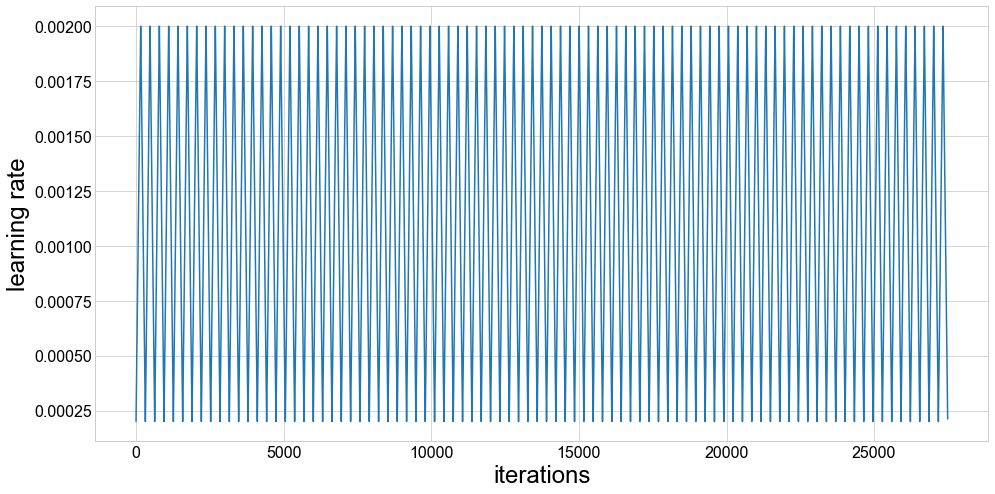

Fold took 357.534s

Training model 5 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279715). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140272). Check your callbacks.
  % delta_t_median)


1 New best found: 4.028387149155606e-05
3 New best found: 3.6062345177924724e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.497475959447911e-05, default loss 3.497475959447911e-05
Saving snapshot 1
4 New best found: 3.497475959447911e-05
5 swa loss 3.497475959447911e-05, default loss 3.498130520165432e-05
5 New best found: 3.497475959447911e-05
6 swa loss 3.497475959447911e-05, default loss 3.4857780500897205e-05
6 New best found: 3.4857780500897205e-05
7 swa loss 3.497475959447911e-05, default loss 3.455653388809878e-05
7 New best found: 3.455653388809878e-05
model is 1 epochs old
8 swa loss 3.432824429764878e-05, default loss 3.4141914221982e-05
Saving snapshot 2
8 New best found: 3.4141914221982e-05
9 swa loss 3.432824429764878e-05, default loss 3.404385510220891e-05
9 New best found: 3.404385510220891e-05
10 swa loss 3.432824429764878e-05, default loss 3.445492484024726e-05
11 swa loss 3.432824429764878e-05, default loss 3.3715428617142604e-05
11 New best found: 3.37154286171

85 swa loss 3.2022983563365416e-05, default loss 3.2047434813284783e-05
85 New best found: 3.2022983563365416e-05
86 swa loss 3.2022983563365416e-05, default loss 3.2420297067437785e-05
86 New best found: 3.2022983563365416e-05
87 swa loss 3.2022983563365416e-05, default loss 3.248958307231078e-05
87 New best found: 3.2022983563365416e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.200362999632489e-05, default loss 3.214460096642142e-05
Saving snapshot 22
88 New best found: 3.200362999632489e-05
89 swa loss 3.200362999632489e-05, default loss 3.230385281349299e-05
89 New best found: 3.200362999632489e-05
90 swa loss 3.200362999632489e-05, default loss 3.2654788097715935e-05
90 New best found: 3.200362999632489e-05
91 swa loss 3.200362999632489e-05, default loss 3.2449153428024145e-05
91 New best found: 3.200362999632489e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.198299592040712e-05, default loss 3.2182871630357115e-05
Saving snapshot 23
92 New

model is 16 epochs old
new model is 6 epochs old
148 swa loss 3.1794358712795654e-05, default loss 3.202183752291603e-05
Saving snapshot 37
148 New best found: 3.1794358712795654e-05
149 swa loss 3.1794358712795654e-05, default loss 3.19531578963506e-05
149 New best found: 3.1794358712795654e-05
150 swa loss 3.1794358712795654e-05, default loss 3.2756771237473004e-05
150 New best found: 3.1794358712795654e-05
151 swa loss 3.1794358712795654e-05, default loss 3.217926896031713e-05
151 New best found: 3.1794358712795654e-05
model is 17 epochs old
new model is 7 epochs old
152 swa loss 3.1793811910029034e-05, default loss 3.2228756012045776e-05
Saving snapshot 38
152 New best found: 3.1793811910029034e-05
153 swa loss 3.1793811910029034e-05, default loss 3.236686341551831e-05
153 New best found: 3.1793811910029034e-05
154 swa loss 3.1793811910029034e-05, default loss 3.2323145191185174e-05
154 New best found: 3.1793811910029034e-05
155 swa loss 3.1793811910029034e-05, default loss 3.22389

209 swa loss 3.1640595401404424e-05, default loss 3.212934812181629e-05
209 New best found: 3.1640595401404424e-05
210 swa loss 3.1640595401404424e-05, default loss 3.2417633292789105e-05
210 New best found: 3.1640595401404424e-05
211 swa loss 3.1640595401404424e-05, default loss 3.2068102396442554e-05
211 New best found: 3.1640595401404424e-05
model is 12 epochs old
new model is 2 epochs old
212 swa loss 3.1629570854420305e-05, default loss 3.187701972929062e-05
Saving snapshot 53
212 New best found: 3.1629570854420305e-05
213 swa loss 3.1629570854420305e-05, default loss 3.1939881449216046e-05
213 New best found: 3.1629570854420305e-05
214 swa loss 3.1629570854420305e-05, default loss 3.223399404378142e-05
214 New best found: 3.1629570854420305e-05
215 swa loss 3.1629570854420305e-05, default loss 3.20536870174692e-05
215 New best found: 3.1629570854420305e-05
model is 13 epochs old
new model is 3 epochs old
216 swa loss 3.1626220322505105e-05, default loss 3.1893868632323575e-05
Sav

274 swa loss 3.1572663082624787e-05, default loss 3.2364558496919926e-05
274 New best found: 3.1572663082624787e-05
275 swa loss 3.1572663082624787e-05, default loss 3.218890976131661e-05
275 New best found: 3.1572663082624787e-05
model is 28 epochs old
new model is 8 epochs old
276 swa loss 3.1572733566281384e-05, default loss 3.1986244396830446e-05
Saving snapshot 69
277 swa loss 3.1572733566281384e-05, default loss 3.209596103260992e-05
278 swa loss 3.1572733566281384e-05, default loss 3.221406566008227e-05
279 swa loss 3.1572733566281384e-05, default loss 3.233591835014522e-05
model is 29 epochs old
new model is 9 epochs old
280 swa loss 3.157363625214202e-05, default loss 3.209182928694645e-05
Saving snapshot 70
281 swa loss 3.157363625214202e-05, default loss 3.2360270447679797e-05
282 swa loss 3.157363625214202e-05, default loss 3.2456739911867773e-05
283 swa loss 3.157363625214202e-05, default loss 3.2128873480542095e-05
model is 30 epochs old
new model is 10 epochs old
284 swa

351 swa loss 3.156558852060698e-05, default loss 3.231437579524936e-05
model is 47 epochs old
new model is 12 epochs old
352 swa loss 3.156646382267354e-05, default loss 3.222087789908983e-05
Saving snapshot 88
Early stopping after 352 epochs
Score is: {'loss': 3.155940834549256e-05, 'wAUC': 0.06226244472951281, 'AUC': 0.09598528155324981, 'AMS': 4.05744361104288, 'cut': 0.9820038676261902}


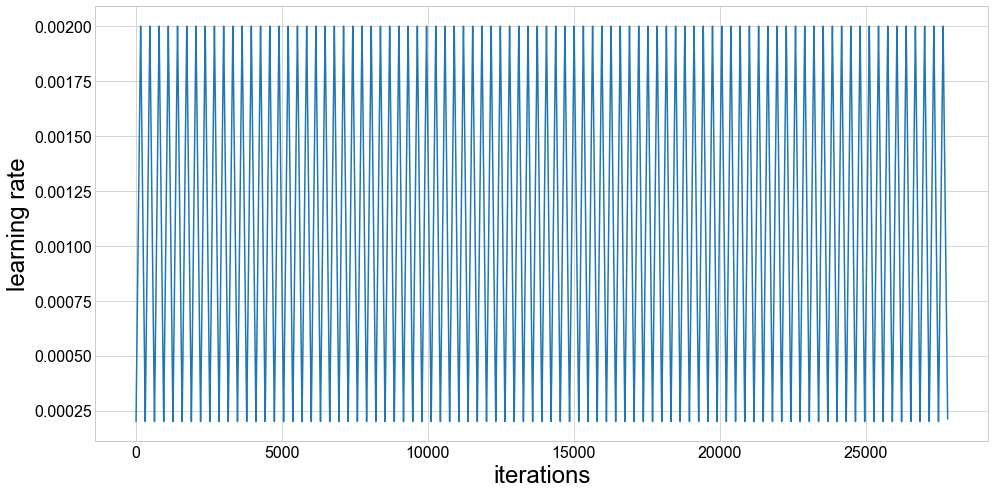

Fold took 376.994s

Training model 6 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284785). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142702). Check your callbacks.
  % delta_t_median)


1 New best found: 4.101678131482866e-05
2 New best found: 3.7139286009588196e-05
3 New best found: 3.587622639088647e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.4691259080352255e-05, default loss 3.4691259080352255e-05
Saving snapshot 1
4 New best found: 3.4691259080352255e-05
5 swa loss 3.4691259080352255e-05, default loss 3.512797759966957e-05
5 New best found: 3.4691259080352255e-05
6 swa loss 3.4691259080352255e-05, default loss 3.569894055800627e-05
6 New best found: 3.4691259080352255e-05
7 swa loss 3.4691259080352255e-05, default loss 3.402986236321158e-05
7 New best found: 3.402986236321158e-05
model is 1 epochs old
8 swa loss 3.3908216119830326e-05, default loss 3.3673783465586516e-05
Saving snapshot 2
8 New best found: 3.3673783465586516e-05
9 swa loss 3.3908216119830326e-05, default loss 3.380380887669721e-05
10 swa loss 3.3908216119830326e-05, default loss 3.375457695346318e-05
11 swa loss 3.3908216119830326e-05, default loss 3.407629757818626e-05
model is 2 epochs

86 swa loss 3.161919369754884e-05, default loss 3.1925301552850104e-05
87 swa loss 3.161919369754884e-05, default loss 3.236537788785995e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.159156908193587e-05, default loss 3.1672310915843375e-05
Saving snapshot 22
89 swa loss 3.159156908193587e-05, default loss 3.1601203848689845e-05
90 swa loss 3.159156908193587e-05, default loss 3.199351374943858e-05
91 swa loss 3.159156908193587e-05, default loss 3.182301568530315e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.1573265834636555e-05, default loss 3.190188544476744e-05
Saving snapshot 23
92 New best found: 3.1573265834636555e-05
93 swa loss 3.1573265834636555e-05, default loss 3.1990156800810695e-05
93 New best found: 3.1573265834636555e-05
94 swa loss 3.1573265834636555e-05, default loss 3.257303395319393e-05
94 New best found: 3.1573265834636555e-05
95 swa loss 3.1573265834636555e-05, default loss 3.176585875585571e-05
95 New best found: 3.157326583

model is 6 epochs old
new model is 1 epochs old
148 swa loss 3.1141843241801084e-05, default loss 3.141282036236815e-05
Saving snapshot 37
148 New best found: 3.1141843241801084e-05
149 swa loss 3.1141843241801084e-05, default loss 3.1427696079539314e-05
149 New best found: 3.1141843241801084e-05
150 swa loss 3.1141843241801084e-05, default loss 3.208086138693597e-05
150 New best found: 3.1141843241801084e-05
151 swa loss 3.1141843241801084e-05, default loss 3.153304998154972e-05
151 New best found: 3.1141843241801084e-05
model is 7 epochs old
new model is 2 epochs old
152 swa loss 3.112724033011016e-05, default loss 3.132689707852478e-05
Saving snapshot 38
152 New best found: 3.112724033011016e-05
153 swa loss 3.112724033011016e-05, default loss 3.1421852227499145e-05
153 New best found: 3.112724033011016e-05
154 swa loss 3.112724033011016e-05, default loss 3.209919356234259e-05
154 New best found: 3.112724033011016e-05
155 swa loss 3.112724033011016e-05, default loss 3.15816114946329

209 swa loss 3.102191447195209e-05, default loss 3.132867826598323e-05
209 New best found: 3.102191447195209e-05
210 swa loss 3.102191447195209e-05, default loss 3.1638762778655456e-05
210 New best found: 3.102191447195209e-05
211 swa loss 3.102191447195209e-05, default loss 3.176590928199505e-05
211 New best found: 3.102191447195209e-05
model is 22 epochs old
new model is 2 epochs old
212 swa loss 3.101830787519169e-05, default loss 3.135493016226526e-05
Saving snapshot 53
212 New best found: 3.101830787519169e-05
213 swa loss 3.101830787519169e-05, default loss 3.152333858057844e-05
213 New best found: 3.101830787519169e-05
214 swa loss 3.101830787519169e-05, default loss 3.193455124448615e-05
214 New best found: 3.101830787519169e-05
215 swa loss 3.101830787519169e-05, default loss 3.1268707044227114e-05
215 New best found: 3.101830787519169e-05
model is 23 epochs old
new model is 3 epochs old
216 swa loss 3.1013033157913457e-05, default loss 3.1277876056465915e-05
Saving snapshot 5

275 swa loss 3.0982808895834845e-05, default loss 3.164811021238964e-05
275 New best found: 3.0982808895834845e-05
model is 38 epochs old
new model is 3 epochs old
276 swa loss 3.0981807842452885e-05, default loss 3.139571121671657e-05
Saving snapshot 69
276 New best found: 3.0981807842452885e-05
277 swa loss 3.0981807842452885e-05, default loss 3.1441532616677575e-05
277 New best found: 3.0981807842452885e-05
278 swa loss 3.0981807842452885e-05, default loss 3.123956992878372e-05
278 New best found: 3.0981807842452885e-05
279 swa loss 3.0981807842452885e-05, default loss 3.154674709945786e-05
279 New best found: 3.0981807842452885e-05
model is 39 epochs old
new model is 4 epochs old
280 swa loss 3.0977986503802006e-05, default loss 3.12102340627124e-05
Saving snapshot 70
280 New best found: 3.0977986503802006e-05
281 swa loss 3.0977986503802006e-05, default loss 3.1404714296538076e-05
281 New best found: 3.0977986503802006e-05
282 swa loss 3.0977986503802006e-05, default loss 3.166690

342 swa loss 3.0969942639059956e-05, default loss 3.2130070393486625e-05
343 swa loss 3.0969942639059956e-05, default loss 3.178123996034999e-05
model is 55 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.0967830590353566e-05, new model: 3.108325064110927e-05
Current model better, renewing
____________________


344 swa loss 3.0967830590353566e-05, default loss 3.143641224018182e-05
Saving snapshot 86
344 New best found: 3.0967830590353566e-05
345 swa loss 3.0967830590353566e-05, default loss 3.137451683497038e-05
345 New best found: 3.0967830590353566e-05
346 swa loss 3.0967830590353566e-05, default loss 3.190029008546291e-05
346 New best found: 3.0967830590353566e-05
347 swa loss 3.0967830590353566e-05, default loss 3.1620186881771084e-05
347 New best found: 3.0967830590353566e-05
model is 56 epochs old
new model is 1 epochs old
348 swa loss 3.0969862231706174e-05, default loss 3.159179463662191e-05
Saving snapshot 87
349 swa loss 3.0969862231706174

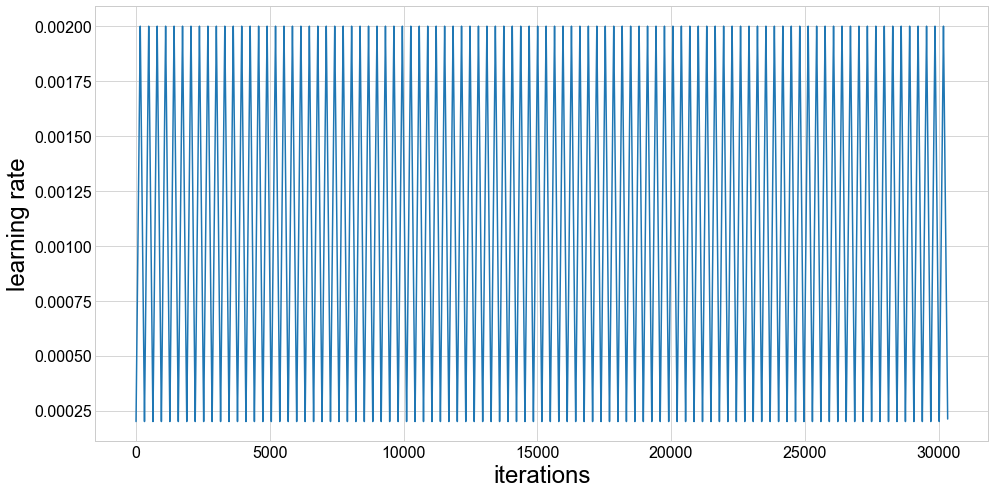

Fold took 417.175s

Training model 7 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.295931). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148321). Check your callbacks.
  % delta_t_median)


1 New best found: 4.06381674023578e-05
2 New best found: 3.6186747450847176e-05
3 New best found: 3.455212818225846e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.3888037776341664e-05, default loss 3.3888037776341664e-05
Saving snapshot 1
4 New best found: 3.3888037776341664e-05
5 swa loss 3.3888037776341664e-05, default loss 3.3807827868440654e-05
5 New best found: 3.3807827868440654e-05
6 swa loss 3.3888037776341664e-05, default loss 3.383004218485439e-05
7 swa loss 3.3888037776341664e-05, default loss 3.314313956652768e-05
7 New best found: 3.314313956652768e-05
model is 1 epochs old
8 swa loss 3.3094266612897624e-05, default loss 3.29013117167051e-05
Saving snapshot 2
8 New best found: 3.29013117167051e-05
9 swa loss 3.3094266612897624e-05, default loss 3.271819017245434e-05
9 New best found: 3.271819017245434e-05
10 swa loss 3.3094266612897624e-05, default loss 3.29352762651979e-05
11 swa loss 3.3094266612897624e-05, default loss 3.308390246966155e-05
model is 2 epochs old
1

86 swa loss 3.097910532815149e-05, default loss 3.154104382992955e-05
86 New best found: 3.097910532815149e-05
87 swa loss 3.097910532815149e-05, default loss 3.1458398065296934e-05
87 New best found: 3.097910532815149e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.095869398239301e-05, default loss 3.112689425906865e-05
Saving snapshot 22
88 New best found: 3.095869398239301e-05
89 swa loss 3.095869398239301e-05, default loss 3.142504886345705e-05
89 New best found: 3.095869398239301e-05
90 swa loss 3.095869398239301e-05, default loss 3.147204979977687e-05
90 New best found: 3.095869398239301e-05
91 swa loss 3.095869398239301e-05, default loss 3.131877431151224e-05
91 New best found: 3.095869398239301e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.0944113308214584e-05, default loss 3.106940610159654e-05
Saving snapshot 23
92 New best found: 3.0944113308214584e-05
93 swa loss 3.0944113308214584e-05, default loss 3.109115487313829e-05
93 New best f

149 swa loss 3.068221124849515e-05, default loss 3.106773790059378e-05
149 New best found: 3.068221124849515e-05
150 swa loss 3.068221124849515e-05, default loss 3.151631747896317e-05
150 New best found: 3.068221124849515e-05
151 swa loss 3.068221124849515e-05, default loss 3.125067751461756e-05
151 New best found: 3.068221124849515e-05
model is 17 epochs old
new model is 7 epochs old
152 swa loss 3.068082539102761e-05, default loss 3.09944658059976e-05
Saving snapshot 38
152 New best found: 3.068082539102761e-05
153 swa loss 3.068082539102761e-05, default loss 3.126233168150066e-05
153 New best found: 3.068082539102761e-05
154 swa loss 3.068082539102761e-05, default loss 3.1135692511452363e-05
154 New best found: 3.068082539102761e-05
155 swa loss 3.068082539102761e-05, default loss 3.128180656203767e-05
155 New best found: 3.068082539102761e-05
model is 18 epochs old
new model is 8 epochs old
156 swa loss 3.067615044419654e-05, default loss 3.103005517841666e-05
Saving snapshot 39
15

215 swa loss 3.056763861823129e-05, default loss 3.1553329082089474e-05
model is 23 epochs old
new model is 8 epochs old
216 swa loss 3.0566776092746294e-05, default loss 3.0867183818190827e-05
Saving snapshot 54
217 swa loss 3.0566776092746294e-05, default loss 3.0809102456260004e-05
218 swa loss 3.0566776092746294e-05, default loss 3.138634064307553e-05
219 swa loss 3.0566776092746294e-05, default loss 3.1174759345594795e-05
model is 24 epochs old
new model is 9 epochs old
220 swa loss 3.057227221943322e-05, default loss 3.118470957997488e-05
Saving snapshot 55
221 swa loss 3.057227221943322e-05, default loss 3.102403219090775e-05
222 swa loss 3.057227221943322e-05, default loss 3.0989610460528635e-05
223 swa loss 3.057227221943322e-05, default loss 3.113127770411666e-05
model is 25 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.05788923666114e-05, new model: 3.062475753904437e-05
Current model better, renewing
____________________


224 swa loss 3

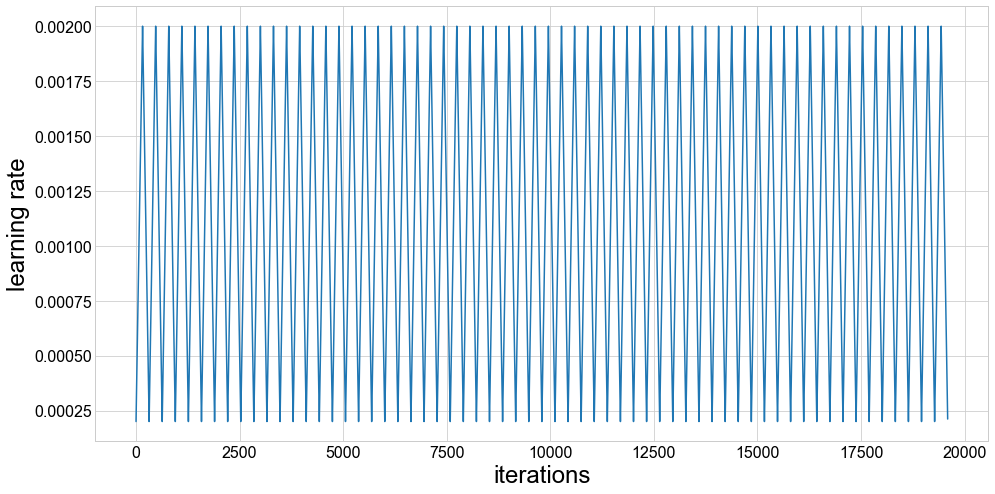

Fold took 279.986s

Training model 8 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314897). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157912). Check your callbacks.
  % delta_t_median)


1 New best found: 4.085439144691918e-05
2 New best found: 3.7532881411607376e-05
3 New best found: 3.6286817623476964e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.577265696512768e-05, default loss 3.577265696512768e-05
Saving snapshot 1
4 New best found: 3.577265696512768e-05
5 swa loss 3.577265696512768e-05, default loss 3.598577217635466e-05
5 New best found: 3.577265696512768e-05
6 swa loss 3.577265696512768e-05, default loss 3.608863331755856e-05
6 New best found: 3.577265696512768e-05
7 swa loss 3.577265696512768e-05, default loss 3.510346604016377e-05
7 New best found: 3.510346604016377e-05
model is 1 epochs old
8 swa loss 3.493632222234737e-05, default loss 3.468548707314767e-05
Saving snapshot 2
8 New best found: 3.468548707314767e-05
9 swa loss 3.493632222234737e-05, default loss 3.5232753419404614e-05
10 swa loss 3.493632222234737e-05, default loss 3.505846434709383e-05
11 swa loss 3.493632222234737e-05, default loss 3.491544779681135e-05
model is 2 epochs old
12 swa 

84 swa loss 3.2702436040563045e-05, default loss 3.2717013596266046e-05
Saving snapshot 21
84 New best found: 3.2702436040563045e-05
85 swa loss 3.2702436040563045e-05, default loss 3.2780110448948105e-05
85 New best found: 3.2702436040563045e-05
86 swa loss 3.2702436040563045e-05, default loss 3.345741845987504e-05
86 New best found: 3.2702436040563045e-05
87 swa loss 3.2702436040563045e-05, default loss 3.2992154685780405e-05
87 New best found: 3.2702436040563045e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.269453079847153e-05, default loss 3.2972628412244376e-05
Saving snapshot 22
88 New best found: 3.269453079847153e-05
89 swa loss 3.269453079847153e-05, default loss 3.3135555109765846e-05
89 New best found: 3.269453079847153e-05
90 swa loss 3.269453079847153e-05, default loss 3.365491746226326e-05
90 New best found: 3.269453079847153e-05
91 swa loss 3.269453079847153e-05, default loss 3.2990818354301155e-05
91 New best found: 3.269453079847153e-05
model is 12

146 swa loss 3.247777451470029e-05, default loss 3.309229119186057e-05
146 New best found: 3.247777451470029e-05
147 swa loss 3.247777451470029e-05, default loss 3.281396192105603e-05
147 New best found: 3.247777451470029e-05
model is 16 epochs old
new model is 6 epochs old
148 swa loss 3.2470229439786634e-05, default loss 3.268019673996605e-05
Saving snapshot 37
148 New best found: 3.2470229439786634e-05
149 swa loss 3.2470229439786634e-05, default loss 3.3049968996056125e-05
149 New best found: 3.2470229439786634e-05
150 swa loss 3.2470229439786634e-05, default loss 3.29614367808972e-05
150 New best found: 3.2470229439786634e-05
151 swa loss 3.2470229439786634e-05, default loss 3.3003945008385925e-05
151 New best found: 3.2470229439786634e-05
model is 17 epochs old
new model is 7 epochs old
152 swa loss 3.245929405456991e-05, default loss 3.275349508767249e-05
Saving snapshot 38
152 New best found: 3.245929405456991e-05
153 swa loss 3.245929405456991e-05, default loss 3.2742097788286

model is 12 epochs old
new model is 2 epochs old
212 swa loss 3.2367211559176214e-05, default loss 3.288905085937586e-05
Saving snapshot 53
213 swa loss 3.2367211559176214e-05, default loss 3.273036531463731e-05
214 swa loss 3.2367211559176214e-05, default loss 3.312572920549428e-05
215 swa loss 3.2367211559176214e-05, default loss 3.297286218148656e-05
model is 13 epochs old
new model is 3 epochs old
216 swa loss 3.237400204525329e-05, default loss 3.2850341605080756e-05
Saving snapshot 54
217 swa loss 3.237400204525329e-05, default loss 3.2648245315795065e-05
218 swa loss 3.237400204525329e-05, default loss 3.299481997819385e-05
219 swa loss 3.237400204525329e-05, default loss 3.2776883488259045e-05
model is 14 epochs old
new model is 4 epochs old
220 swa loss 3.236348158607143e-05, default loss 3.257855847477913e-05
Saving snapshot 55
221 swa loss 3.236348158607143e-05, default loss 3.275504949851893e-05
222 swa loss 3.236348158607143e-05, default loss 3.3444815430993914e-05
223 swa

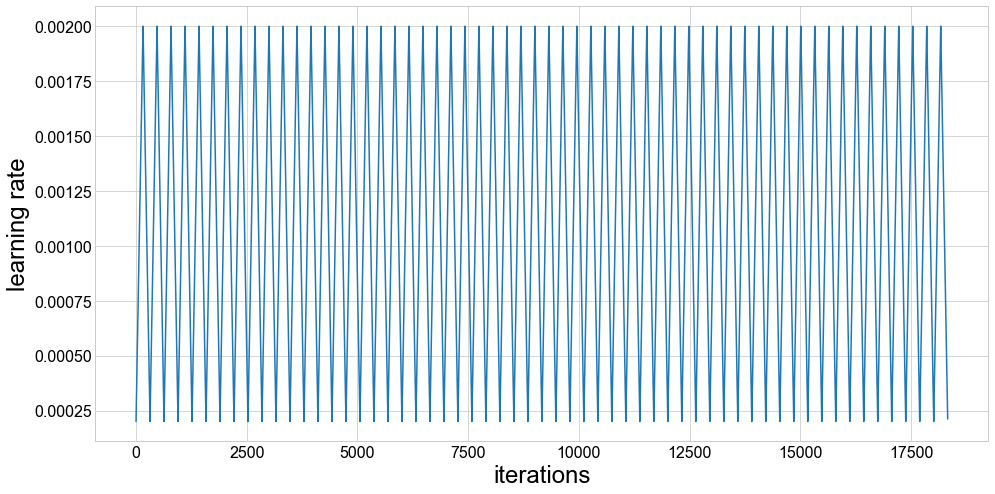

Fold took 278.815s

Training model 9 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.338560). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.169899). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0392630038950104e-05
2 New best found: 3.8077452041590014e-05
3 New best found: 3.546353681062622e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.512358842440872e-05, default loss 3.512358842440872e-05
Saving snapshot 1
4 New best found: 3.512358842440872e-05
5 swa loss 3.512358842440872e-05, default loss 3.499384543547617e-05
5 New best found: 3.499384543547617e-05
6 swa loss 3.512358842440872e-05, default loss 3.53359452202927e-05
7 swa loss 3.512358842440872e-05, default loss 3.4389389374928675e-05
7 New best found: 3.4389389374928675e-05
model is 1 epochs old
8 swa loss 3.418700786639111e-05, default loss 3.3863223130693485e-05
Saving snapshot 2
8 New best found: 3.3863223130693485e-05
9 swa loss 3.418700786639111e-05, default loss 3.3954736700669835e-05
10 swa loss 3.418700786639111e-05, default loss 3.456822742682528e-05
11 swa loss 3.418700786639111e-05, default loss 3.4151627272863425e-05
model is 2 epochs old
12 swa loss 3.3759446326131056e-05, default

model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.219315197475539e-05, default loss 3.241107842488432e-05
Saving snapshot 22
88 New best found: 3.219315197475539e-05
89 swa loss 3.219315197475539e-05, default loss 3.2627324651237484e-05
89 New best found: 3.219315197475539e-05
90 swa loss 3.219315197475539e-05, default loss 3.302883287716212e-05
90 New best found: 3.219315197475539e-05
91 swa loss 3.219315197475539e-05, default loss 3.2733641066034966e-05
91 New best found: 3.219315197475539e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.217997905621115e-05, default loss 3.234516813825074e-05
Saving snapshot 23
92 New best found: 3.217997905621115e-05
93 swa loss 3.217997905621115e-05, default loss 3.2427795663243394e-05
93 New best found: 3.217997905621115e-05
94 swa loss 3.217997905621115e-05, default loss 3.270839882921615e-05
94 New best found: 3.217997905621115e-05
95 swa loss 3.217997905621115e-05, default loss 3.258187474552244e-05
95 New best fo

model is 12 epochs old
new model is 2 epochs old
152 swa loss 3.202547315449381e-05, default loss 3.228565238645345e-05
Saving snapshot 38
152 New best found: 3.202547315449381e-05
153 swa loss 3.202547315449381e-05, default loss 3.231005987188276e-05
153 New best found: 3.202547315449381e-05
154 swa loss 3.202547315449381e-05, default loss 3.2788908937771374e-05
154 New best found: 3.202547315449381e-05
155 swa loss 3.202547315449381e-05, default loss 3.25755387498413e-05
155 New best found: 3.202547315449381e-05
model is 13 epochs old
new model is 3 epochs old
156 swa loss 3.20221077948251e-05, default loss 3.23530314254528e-05
Saving snapshot 39
156 New best found: 3.20221077948251e-05
157 swa loss 3.20221077948251e-05, default loss 3.235427511300736e-05
157 New best found: 3.20221077948251e-05
158 swa loss 3.20221077948251e-05, default loss 3.2753408348829505e-05
158 New best found: 3.20221077948251e-05
159 swa loss 3.20221077948251e-05, default loss 3.2538130493738935e-05
159 New 

214 swa loss 3.1930342201916124e-05, default loss 3.2445687806011214e-05
214 New best found: 3.1930342201916124e-05
215 swa loss 3.1930342201916124e-05, default loss 3.2451166815633374e-05
215 New best found: 3.1930342201916124e-05
model is 18 epochs old
new model is 3 epochs old
216 swa loss 3.192626720647126e-05, default loss 3.214232927417557e-05
Saving snapshot 54
216 New best found: 3.192626720647126e-05
217 swa loss 3.192626720647126e-05, default loss 3.256854093790657e-05
217 New best found: 3.192626720647126e-05
218 swa loss 3.192626720647126e-05, default loss 3.2784626758560385e-05
218 New best found: 3.192626720647126e-05
219 swa loss 3.192626720647126e-05, default loss 3.264852252222486e-05
219 New best found: 3.192626720647126e-05
model is 19 epochs old
new model is 4 epochs old
220 swa loss 3.1926288297144565e-05, default loss 3.2297169452551437e-05
Saving snapshot 55
221 swa loss 3.1926288297144565e-05, default loss 3.250746026066981e-05
222 swa loss 3.1926288297144565e-0

281 swa loss 3.188572128168247e-05, default loss 3.212740123539204e-05
281 New best found: 3.188572128168247e-05
282 swa loss 3.188572128168247e-05, default loss 3.235936851097243e-05
282 New best found: 3.188572128168247e-05
283 swa loss 3.188572128168247e-05, default loss 3.230761079122519e-05
283 New best found: 3.188572128168247e-05
model is 35 epochs old
new model is 10 epochs old
284 swa loss 3.1878367476214655e-05, default loss 3.206161925712974e-05
Saving snapshot 71
284 New best found: 3.1878367476214655e-05
285 swa loss 3.1878367476214655e-05, default loss 3.2092045839655846e-05
285 New best found: 3.1878367476214655e-05
286 swa loss 3.1878367476214655e-05, default loss 3.280409687579533e-05
286 New best found: 3.1878367476214655e-05
287 swa loss 3.1878367476214655e-05, default loss 3.288591131341131e-05
287 New best found: 3.1878367476214655e-05
model is 36 epochs old
new model is 11 epochs old
288 swa loss 3.1874943338569416e-05, default loss 3.218587765533211e-05
Saving sn

model is 53 epochs old
new model is 13 epochs old
356 swa loss 3.186585437099848e-05, default loss 3.227795200448101e-05
Saving snapshot 89
357 swa loss 3.186585437099848e-05, default loss 3.2428739145427036e-05
358 swa loss 3.186585437099848e-05, default loss 3.314717821290864e-05
359 swa loss 3.186585437099848e-05, default loss 3.239179366724867e-05
model is 54 epochs old
new model is 14 epochs old
360 swa loss 3.1865072646274054e-05, default loss 3.233075992770976e-05
Saving snapshot 90
360 New best found: 3.1865072646274054e-05
361 swa loss 3.1865072646274054e-05, default loss 3.233098327986892e-05
361 New best found: 3.1865072646274054e-05
362 swa loss 3.1865072646274054e-05, default loss 3.2576643398705944e-05
362 New best found: 3.1865072646274054e-05
363 swa loss 3.1865072646274054e-05, default loss 3.248656979097942e-05
363 New best found: 3.1865072646274054e-05
model is 55 epochs old
new model is 15 epochs old
364 swa loss 3.186492376734348e-05, default loss 3.231851073958976

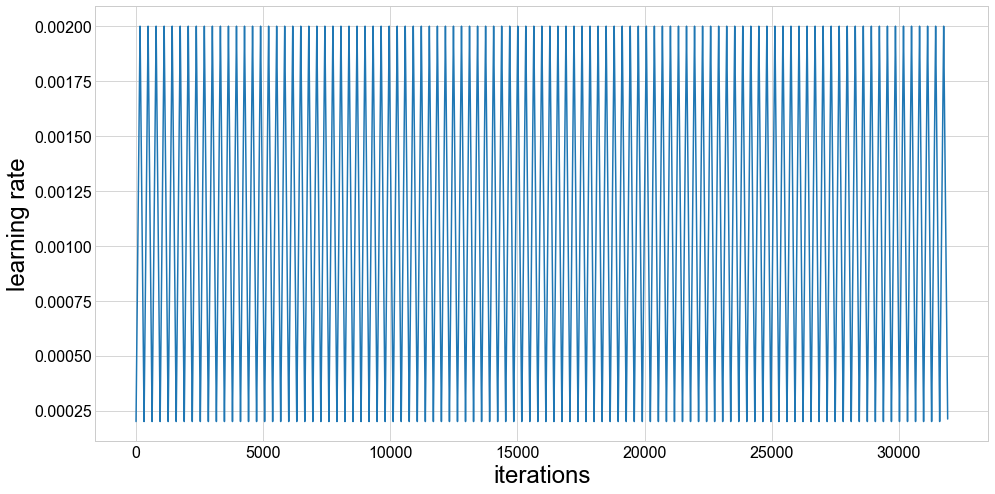

Fold took 494.009s

Training model 10 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.361754). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.181393). Check your callbacks.
  % delta_t_median)


1 New best found: 4.028907482279465e-05
2 New best found: 3.8570074884046336e-05
3 New best found: 3.546732406393858e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.463316378765739e-05, default loss 3.463316378765739e-05
Saving snapshot 1
4 New best found: 3.463316378765739e-05
5 swa loss 3.463316378765739e-05, default loss 3.486399237444857e-05
5 New best found: 3.463316378765739e-05
6 swa loss 3.463316378765739e-05, default loss 3.4897848466061984e-05
6 New best found: 3.463316378765739e-05
7 swa loss 3.463316378765739e-05, default loss 3.475983859098051e-05
7 New best found: 3.463316378765739e-05
model is 1 epochs old
8 swa loss 3.393871749431128e-05, default loss 3.371330126537941e-05
Saving snapshot 2
8 New best found: 3.371330126537941e-05
9 swa loss 3.393871749431128e-05, default loss 3.397164035704918e-05
10 swa loss 3.393871749431128e-05, default loss 3.492833683849312e-05
11 swa loss 3.393871749431128e-05, default loss 3.361133460566634e-05
11 New best found: 3.361133460

86 swa loss 3.181489814596716e-05, default loss 3.244314171897713e-05
86 New best found: 3.181489814596716e-05
87 swa loss 3.181489814596716e-05, default loss 3.247046685864916e-05
87 New best found: 3.181489814596716e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.180989479005803e-05, default loss 3.202428990334738e-05
Saving snapshot 22
88 New best found: 3.180989479005803e-05
89 swa loss 3.180989479005803e-05, default loss 3.200790761620738e-05
89 New best found: 3.180989479005803e-05
90 swa loss 3.180989479005803e-05, default loss 3.2462542194116395e-05
90 New best found: 3.180989479005803e-05
91 swa loss 3.180989479005803e-05, default loss 3.221134760096902e-05
91 New best found: 3.180989479005803e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.1796882819617165e-05, default loss 3.196095414168667e-05
Saving snapshot 23
92 New best found: 3.1796882819617165e-05
93 swa loss 3.1796882819617165e-05, default loss 3.226217505434761e-05
93 New best f

146 swa loss 3.152453509101179e-05, default loss 3.216213512205286e-05
146 New best found: 3.152453509101179e-05
147 swa loss 3.152453509101179e-05, default loss 3.207233972643735e-05
147 New best found: 3.152453509101179e-05
model is 11 epochs old
new model is 1 epochs old
148 swa loss 3.1515933635819235e-05, default loss 3.1825222923362164e-05
Saving snapshot 37
148 New best found: 3.1515933635819235e-05
149 swa loss 3.1515933635819235e-05, default loss 3.2016792162903585e-05
149 New best found: 3.1515933635819235e-05
150 swa loss 3.1515933635819235e-05, default loss 3.222998785495292e-05
150 New best found: 3.1515933635819235e-05
151 swa loss 3.1515933635819235e-05, default loss 3.23157685197657e-05
151 New best found: 3.1515933635819235e-05
model is 12 epochs old
new model is 2 epochs old
152 swa loss 3.1521479185903446e-05, default loss 3.193541671789717e-05
Saving snapshot 38
153 swa loss 3.1521479185903446e-05, default loss 3.181850206310628e-05
154 swa loss 3.1521479185903446e-

model is 16 epochs old
new model is 1 epochs old
208 swa loss 3.137722770334221e-05, default loss 3.1603925518720645e-05
Saving snapshot 52
208 New best found: 3.137722770334221e-05
209 swa loss 3.137722770334221e-05, default loss 3.1665617086400746e-05
209 New best found: 3.137722770334221e-05
210 swa loss 3.137722770334221e-05, default loss 3.203362587082665e-05
210 New best found: 3.137722770334221e-05
211 swa loss 3.137722770334221e-05, default loss 3.180629061316722e-05
211 New best found: 3.137722770334221e-05
model is 17 epochs old
new model is 2 epochs old
212 swa loss 3.1366997497389095e-05, default loss 3.157106867583934e-05
Saving snapshot 53
212 New best found: 3.1366997497389095e-05
213 swa loss 3.1366997497389095e-05, default loss 3.1747284516313815e-05
213 New best found: 3.1366997497389095e-05
214 swa loss 3.1366997497389095e-05, default loss 3.215574970236048e-05
214 New best found: 3.1366997497389095e-05
215 swa loss 3.1366997497389095e-05, default loss 3.199279465043

270 swa loss 3.1267722755001156e-05, default loss 3.181968525605043e-05
271 swa loss 3.1267722755001156e-05, default loss 3.195888187037781e-05
model is 7 epochs old
new model is 2 epochs old
272 swa loss 3.1267824511451183e-05, default loss 3.16901729485835e-05
Saving snapshot 68
273 swa loss 3.1267824511451183e-05, default loss 3.1588559251395054e-05
274 swa loss 3.1267824511451183e-05, default loss 3.191127790196333e-05
275 swa loss 3.1267824511451183e-05, default loss 3.1849313291604633e-05
model is 8 epochs old
new model is 3 epochs old
276 swa loss 3.125045469787438e-05, default loss 3.154521671676775e-05
Saving snapshot 69
276 New best found: 3.125045469787438e-05
277 swa loss 3.125045469787438e-05, default loss 3.1754524023563137e-05
277 New best found: 3.125045469787438e-05
278 swa loss 3.125045469787438e-05, default loss 3.169531109015224e-05
278 New best found: 3.125045469787438e-05
279 swa loss 3.125045469787438e-05, default loss 3.144175584748155e-05
279 New best found: 3.

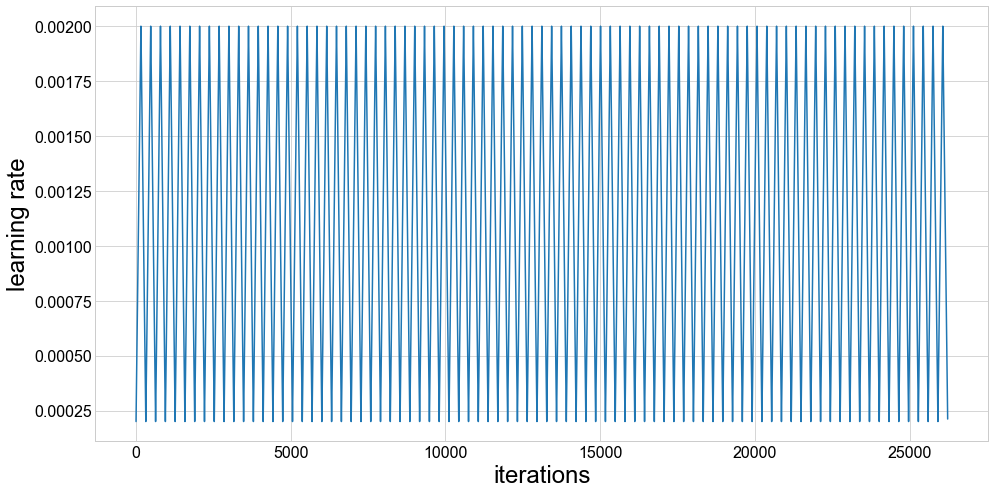

Fold took 430.288s


______________________________________
Training finished
Cross-validation took 3463.269s 


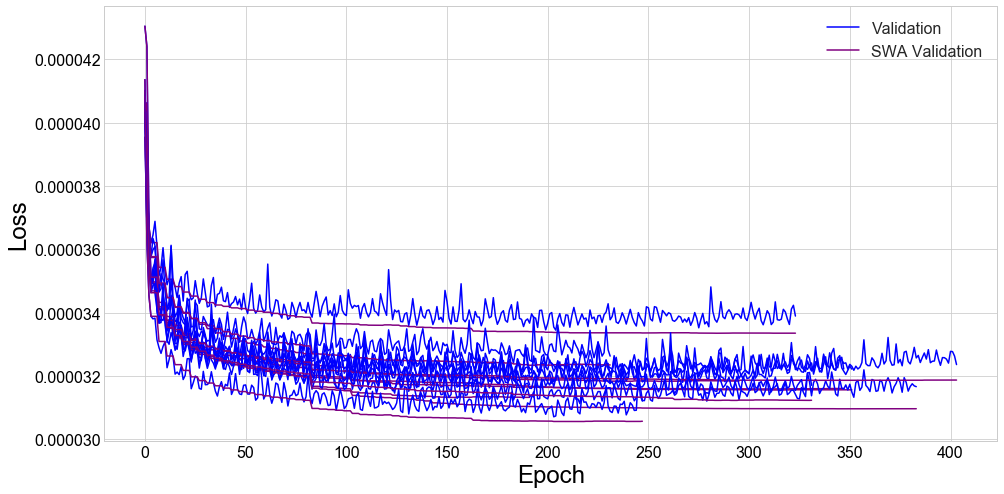

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.063 +- 0.0009
Mean AUC = 0.0984 +- 0.0008
Mean AMS = 3.92 +- 0.07
Mean cut = 0.958 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [11]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
%%capture --no-stdout
ensemble, weights = assemble_ensemble(results, ensemble_size, metric=ensemble_mode)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.0565530009334906e-05
Model 1 is 5 with loss = 3.0967830590353566e-05
Model 2 is 9 with loss = 3.123298860446084e-05
Model 3 is 0 with loss = 3.132657496218732e-05
Model 4 is 4 with loss = 3.155940834549256e-05
Model 5 is 3 with loss = 3.1591543385424834e-05
Model 6 is 2 with loss = 3.183417565823916e-05
Model 7 is 8 with loss = 3.186492376734348e-05
Model 8 is 7 with loss = 3.234335258748615e-05
Model 9 is 1 with loss = 3.335418951044395e-05


## Response on validation data without TTA

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0010120137186000648s per sample

Predicting fold 2 out of 10
Prediction took 0.0002375341158000083s per sample

Predicting fold 3 out of 10
Prediction took 0.00024552251840013925s per sample

Predicting fold 4 out of 10
Prediction took 0.00024291541620004864s per sample

Predicting fold 5 out of 10
Prediction took 0.00021909293480002815s per sample

Predicting fold 6 out of 10
Prediction took 0.00020956570819998888s per sample

Predicting fold 7 out of 10
Prediction took 0.00020661988660012866s per sample

Predicting fold 8 out of 10
Prediction took 0.00020153643960002228s per sample

Predicting fold 9 out of 10
Prediction took 0.0002030018782001207s per sample

Predicting fold 10 out of 10
Prediction took 0.00020267668299984507s per sample



In [15]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [16]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9031356819394606, weighted 0.9361385764090873


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9615166520809865 corresponds to AMS of 3.8336489525501576
Maximum AMS for data is 3.9000696022520196 at cut of 0.9601771235466003
CPU times: user 13.8 s, sys: 54.3 ms, total: 13.8 s
Wall time: 13.9 s


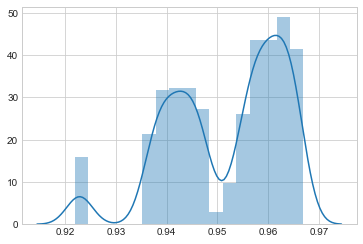

In [17]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95176446 corresponds to AMS of 3.7578690859512527
Maximum AMS for data is 3.9000696022520196 at cut of 0.9601771235466003
CPU times: user 101 ms, sys: 10.7 ms, total: 112 ms
Wall time: 49.1 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


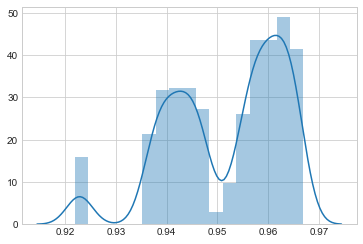

In [18]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [23]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [24]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017313397093999812s per sample

Predicting fold 2 out of 10
Prediction took 0.00166202231139996s per sample

Predicting fold 3 out of 10
Prediction took 0.0017720286317999124s per sample

Predicting fold 4 out of 10
Prediction took 0.0017235220649999975s per sample

Predicting fold 5 out of 10
Prediction took 0.0017298992594000082s per sample

Predicting fold 6 out of 10
Prediction took 0.0017327007521998894s per sample

Predicting fold 7 out of 10
Prediction took 0.0018227965362000759s per sample

Predicting fold 8 out of 10
Prediction took 0.00183517205140015s per sample

Predicting fold 9 out of 10
Prediction took 0.001773094031599976s per sample

Predicting fold 10 out of 10
Prediction took 0.0018885913492000326s per sample



In [25]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [26]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9032297006289638, weighted 0.9361646017187287


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9624000785348413 corresponds to AMS of 3.8544564276366478
Maximum AMS for data is 3.8982669989157444 at cut of 0.9603313207626343
CPU times: user 13.6 s, sys: 22.8 ms, total: 13.6 s
Wall time: 13.6 s


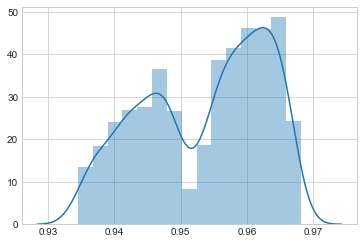

In [27]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9536416 corresponds to AMS of 3.75998688741025
Maximum AMS for data is 3.8982669989157444 at cut of 0.9603313207626343
CPU times: user 69.1 ms, sys: 8.19 ms, total: 77.2 ms
Wall time: 62.1 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


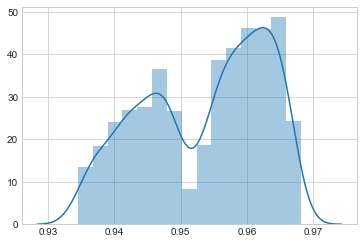

In [28]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [19]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [20]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00021493796258182556s per sample

Predicting fold 2 out of 10
Prediction took 0.00021669144107272587s per sample

Predicting fold 3 out of 10
Prediction took 0.0002156018572363709s per sample

Predicting fold 4 out of 10
Prediction took 0.00021215693038181845s per sample

Predicting fold 5 out of 10
Prediction took 0.0002068093336181846s per sample

Predicting fold 6 out of 10
Prediction took 0.00021157490792727253s per sample

Predicting fold 7 out of 10
Prediction took 0.00021368110905454655s per sample

Predicting fold 8 out of 10
Prediction took 0.00020158482056363442s per sample

Predicting fold 9 out of 10
Prediction took 0.0002187280650000089s per sample

Predicting fold 10 out of 10
Prediction took 0.00021042146529090877s per sample

CPU times: user 2min 11s, sys: 13.5 s, total: 2min 25s
Wall time: 1min 56s


In [21]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.687539513161779 : 3.7766202696919335


(3.687539513161779, 3.7766202696919335)

In [22]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.818974921975163 : 3.8124137295061673


(3.818974921975163, 3.8124137295061673)

# Test scoring - With TTA

In [29]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [30]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0016666546833272646s per sample

Predicting fold 2 out of 10
Prediction took 0.0016602013942181822s per sample

Predicting fold 3 out of 10
Prediction took 0.0016732123376363565s per sample

Predicting fold 4 out of 10
Prediction took 0.0017350199131636393s per sample

Predicting fold 5 out of 10
Prediction took 0.0016515383380545576s per sample

Predicting fold 6 out of 10
Prediction took 0.00165932964412727s per sample

Predicting fold 7 out of 10
Prediction took 0.0016565986311999784s per sample

Predicting fold 8 out of 10
Prediction took 0.0016470799812181873s per sample

Predicting fold 9 out of 10
Prediction took 0.0016374247946181805s per sample

Predicting fold 10 out of 10
Prediction took 0.0016860445358000023s per sample

CPU times: user 17min 11s, sys: 1min 43s, total: 18min 55s
Wall time: 15min 17s


In [31]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.6504640173240293 : 3.7610796989409083


(3.6504640173240293, 3.7610796989409083)

In [32]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.831193123960973 : 3.7951986985440813


(3.831193123960973, 3.7951986985440813)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)